In [ ]:
# importing prerequisites
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
fname = 'examples.tar.gz'
url = 'https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/' + fname
r = requests.get(url)
open(fname , 'wb').write(r.content)

# Extracting the dataset
tar = tarfile.open(fname)
tar.extractall()
tar.close()

# Verifying the file was extracted properly
data_path = "examples/"
path.exists(data_path)

6461141

In [ ]:
# Define color code
colors = {'title': (255, 0, 0),
          'text': (0, 255, 0),
          'figure': (0, 0, 255),
          'table': (255, 255, 0),
          'list': (0, 255, 255)}


# Function to viz the annotation
def markup(image, annotations):
    ''' 
    Draws the segmentation, bounding box, and label of each annotation
    '''
    draw = ImageDraw.Draw(image, 'RGBA')
    for annotation in annotations:
        # Draw segmentation
        draw.polygon(annotation['segmentation'][0],
                     fill=colors[samples['categories'][annotation['category_id'] - 1]['name']] + (64,))
        # Draw bbox
        draw.rectangle(
            (annotation['bbox'][0],
             annotation['bbox'][1],
             annotation['bbox'][0] + annotation['bbox'][2],
             annotation['bbox'][1] + annotation['bbox'][3]),
            outline=colors[samples['categories'][annotation['category_id'] - 1]['name']] + (255,),
            width=2
        )
        # Draw label
        w, h = draw.textsize(text=samples['categories'][annotation['category_id'] - 1]['name'],
                             font=font)
        if annotation['bbox'][3] < h:
            draw.rectangle(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + annotation['bbox'][2] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1]),
                text=samples['categories'][annotation['category_id'] - 1]['name'],
                fill=(255, 255, 255, 255),
                font=font
            )
        else:
            draw.rectangle(
                (annotation['bbox'][0],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0],
                 annotation['bbox'][1]),
                text=samples['categories'][annotation['category_id'] - 1]['name'],
                fill=(255, 255, 255, 255),
                font=font
            )
    return np.array(image)

In [ ]:
# Parse the JSON file and read all the images and labels
with open('examples/samples.json', 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    images[image['id']] = {'file_name': "examples/" + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)

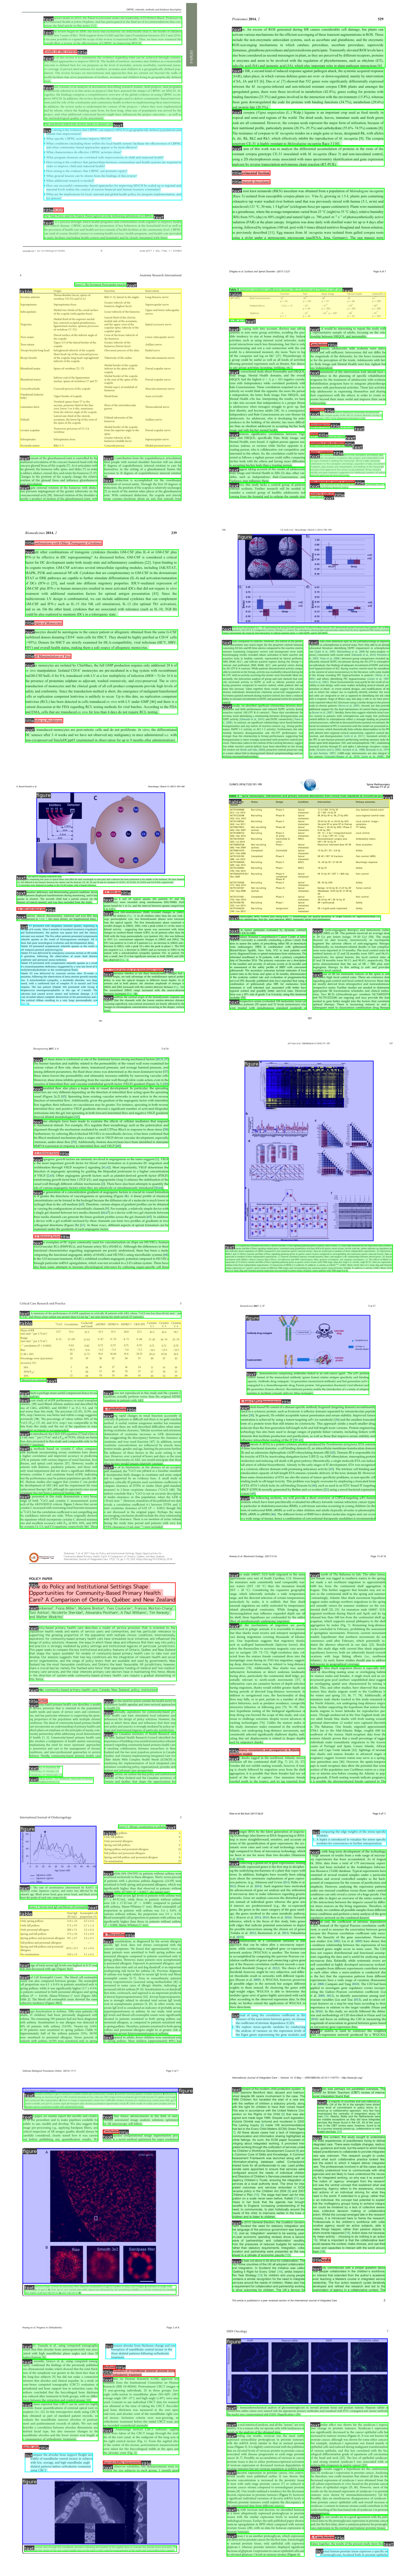

In [ ]:
# Visualize annotations
font = ImageFont.truetype("examples/DejaVuSans.ttf", 15)
fig=plt.figure(figsize=(16, 100))
for i, (_, image) in enumerate(images.items()):
    with Image.open(image['file_name']) as img:
        ax = plt.subplot(int(len(images) / 2), 2, i + 1)
        ax.imshow(markup(img, image['annotations']))
        ax.axis('off')
plt.subplots_adjust(hspace=0, wspace=0)

In [39]:
!pip install huggingface-hub
!pip install transformers
!pip install timm

!pip install streamlit
!sudo apt install tesseract-ocr
!pip install pytesseract
!npm install localtunnel

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 1.589s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [40]:
%%writefile app.py

import streamlit as st
from PIL import Image, ImageEnhance
import statistics
import os
import string
from collections import Counter
from itertools import tee, count
# import TDTSR
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'
from pytesseract import Output
import json
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
# from transformers import TrOCRProcessor, VisionEncoderDecoderModel
# from cv2 import dnn_superres
from transformers import DetrFeatureExtractor
#from transformers import DetrForObjectDetection
from transformers import TableTransformerForObjectDetection
import torch
import asyncio
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


st.set_option('deprecation.showPyplotGlobalUse', False)
st.set_page_config(layout='wide')
st.title("Table Detection and Table Structure Recognition")
st.write("Implemented by MSFT team: https://github.com/microsoft/table-transformer")



def PIL_to_cv(pil_img):
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

def cv_to_PIL(cv_img):
    return Image.fromarray(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))


async def pytess(cell_pil_img):
    return ' '.join(pytesseract.image_to_data(cell_pil_img, output_type=Output.DICT, config='-c tessedit_char_blacklist=œ˜â€œï¬â™Ã©œ¢!|”?«“¥ --psm 6 preserve_interword_spaces')['text']).strip()


# def super_res(pil_img):
    # '''
    # Useful for low-res docs
    # '''
    # requires opencv-contrib-python installed without the opencv-python
    # sr = dnn_superres.DnnSuperResImpl_create()
    # image = PIL_to_cv(pil_img)
    # model_path = "/data/Salman/TRD/code/table-transformer/transformers/LapSRN_x2.pb"
    # model_name = 'lapsrn'
    # model_scale = 2
    # sr.readModel(model_path)
    # sr.setModel(model_name, model_scale)
    # final_img = sr.upsample(image)
    # final_img = cv_to_PIL(final_img)

    # return final_img


def sharpen_image(pil_img):

    img = PIL_to_cv(pil_img)
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])

    sharpen = cv2.filter2D(img, -1, sharpen_kernel)
    pil_img = cv_to_PIL(sharpen)
    return pil_img


def uniquify(seq, suffs = count(1)):
    """Make all the items unique by adding a suffix (1, 2, etc).
    Credit: https://stackoverflow.com/questions/30650474/python-rename-duplicates-in-list-with-progressive-numbers-without-sorting-list
    `seq` is mutable sequence of strings.
    `suffs` is an optional alternative suffix iterable.
    """
    not_unique = [k for k,v in Counter(seq).items() if v>1]

    suff_gens = dict(zip(not_unique, tee(suffs, len(not_unique))))
    for idx,s in enumerate(seq):
        try:
            suffix = str(next(suff_gens[s]))
        except KeyError:
            continue
        else:
            seq[idx] += suffix

    return seq

def binarizeBlur_image(pil_img):
    image = PIL_to_cv(pil_img)
    thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)[1]

    result = cv2.GaussianBlur(thresh, (5,5), 0)
    result = 255 - result
    return cv_to_PIL(result)



def td_postprocess(pil_img):
    '''
    Removes gray background from tables
    '''
    img = PIL_to_cv(pil_img)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (0, 0, 100), (255, 5, 255)) # (0, 0, 100), (255, 5, 255)
    nzmask = cv2.inRange(hsv, (0, 0, 5), (255, 255, 255)) # (0, 0, 5), (255, 255, 255))
    nzmask = cv2.erode(nzmask, np.ones((3,3))) # (3,3)
    mask = mask & nzmask

    new_img = img.copy()
    new_img[np.where(mask)] = 255


    return cv_to_PIL(new_img)

# def super_res(pil_img):
#     # requires opencv-contrib-python installed without the opencv-python
#     sr = dnn_superres.DnnSuperResImpl_create()
#     image = PIL_to_cv(pil_img)
#     model_path = "./LapSRN_x8.pb"
#     model_name = model_path.split('/')[1].split('_')[0].lower()
#     model_scale = int(model_path.split('/')[1].split('_')[1].split('.')[0][1])

#     sr.readModel(model_path)
#     sr.setModel(model_name, model_scale)
#     final_img = sr.upsample(image)
#     final_img = cv_to_PIL(final_img)

#     return final_img

def table_detector(image, THRESHOLD_PROBA):
    '''
    Table detection using DEtect-object TRansformer pre-trained on 1 million tables
    '''

    feature_extractor = DetrFeatureExtractor(do_resize=True, size=800, max_size=800)
    encoding = feature_extractor(image, return_tensors="pt")

    model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

    with torch.no_grad():
        outputs = model(**encoding)

    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > THRESHOLD_PROBA

    target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
    postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
    bboxes_scaled = postprocessed_outputs[0]['boxes'][keep]

    return (model, probas[keep], bboxes_scaled)


def table_struct_recog(image, THRESHOLD_PROBA):
    '''
    Table structure recognition using DEtect-object TRansformer pre-trained on 1 million tables
    '''

    feature_extractor = DetrFeatureExtractor(do_resize=True, size=1000, max_size=1000)
    encoding = feature_extractor(image, return_tensors="pt")

    model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")
    with torch.no_grad():
        outputs = model(**encoding)

    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > THRESHOLD_PROBA

    target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
    postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
    bboxes_scaled = postprocessed_outputs[0]['boxes'][keep]

    return (model, probas[keep], bboxes_scaled)





class TableExtractionPipeline():

    colors = ["red", "blue", "green", "yellow", "orange", "violet"]

    # colors = ["red", "blue", "green", "red", "red", "red"]

    def add_padding(self, pil_img, top, right, bottom, left, color=(255,255,255)):
        '''
        Image padding as part of TSR pre-processing to prevent missing table edges
        '''
        width, height = pil_img.size
        new_width = width + right + left
        new_height = height + top + bottom
        result = Image.new(pil_img.mode, (new_width, new_height), color)
        result.paste(pil_img, (left, top))
        return result

    def plot_results_detection(self, c1, model, pil_img, prob, boxes, delta_xmin, delta_ymin, delta_xmax, delta_ymax):
        '''
        crop_tables and plot_results_detection must have same co-ord shifts because 1 only plots the other one updates co-ordinates
        '''
        # st.write('img_obj')
        # st.write(pil_img)
        plt.imshow(pil_img)
        ax = plt.gca()

        for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
            cl = p.argmax()
            xmin, ymin, xmax, ymax = xmin-delta_xmin, ymin-delta_ymin, xmax+delta_xmax, ymax+delta_ymax
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,fill=False, color='red', linewidth=3))
            text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
            ax.text(xmin-20, ymin-50, text, fontsize=10,bbox=dict(facecolor='yellow', alpha=0.5))
        plt.axis('off')
        c1.pyplot()


    def crop_tables(self, pil_img, prob, boxes, delta_xmin, delta_ymin, delta_xmax, delta_ymax):
        '''
        crop_tables and plot_results_detection must have same co-ord shifts because 1 only plots the other one updates co-ordinates
        '''
        cropped_img_list = []

        for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):

            xmin, ymin, xmax, ymax = xmin-delta_xmin, ymin-delta_ymin, xmax+delta_xmax, ymax+delta_ymax
            cropped_img = pil_img.crop((xmin, ymin, xmax, ymax))
            cropped_img_list.append(cropped_img)


        return cropped_img_list

    def generate_structure(self, c2, model, pil_img, prob, boxes, expand_rowcol_bbox_top, expand_rowcol_bbox_bottom):
        '''
        Co-ordinates are adjusted here by 3 'pixels'
        To plot table pillow image and the TSR bounding boxes on the table
        '''
        # st.write('img_obj')
        # st.write(pil_img)
        plt.figure(figsize=(32,20))
        plt.imshow(pil_img)
        ax = plt.gca()
        rows = {}
        cols = {}
        idx = 0


        for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):

            xmin, ymin, xmax, ymax = xmin, ymin, xmax, ymax
            cl = p.argmax()
            class_text = model.config.id2label[cl.item()]
            text = f'{class_text}: {p[cl]:0.2f}'
            # or (class_text == 'table column')
            if (class_text == 'table row')  or (class_text =='table projected row header') or (class_text == 'table column'):
                ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,fill=False, color=self.colors[cl.item()], linewidth=2))
                ax.text(xmin-10, ymin-10, text, fontsize=5, bbox=dict(facecolor='yellow', alpha=0.5))

            if class_text == 'table row':
                rows['table row.'+str(idx)] = (xmin, ymin-expand_rowcol_bbox_top, xmax, ymax+expand_rowcol_bbox_bottom)
            if class_text == 'table column':
                cols['table column.'+str(idx)] = (xmin, ymin-expand_rowcol_bbox_top, xmax, ymax+expand_rowcol_bbox_bottom)

            idx += 1


        plt.axis('on')
        c2.pyplot()
        return rows, cols

    def sort_table_featuresv2(self, rows:dict, cols:dict):
        # Sometimes the header and first row overlap, and we need the header bbox not to have first row's bbox inside the headers bbox
        rows_ = {table_feature : (xmin, ymin, xmax, ymax) for table_feature, (xmin, ymin, xmax, ymax) in sorted(rows.items(), key=lambda tup: tup[1][1])}
        cols_ = {table_feature : (xmin, ymin, xmax, ymax) for table_feature, (xmin, ymin, xmax, ymax) in sorted(cols.items(), key=lambda tup: tup[1][0])}

        return rows_, cols_

    def individual_table_featuresv2(self, pil_img, rows:dict, cols:dict):

        for k, v in rows.items():
            xmin, ymin, xmax, ymax = v
            cropped_img = pil_img.crop((xmin, ymin, xmax, ymax))
            rows[k] = xmin, ymin, xmax, ymax, cropped_img

        for k, v in cols.items():
            xmin, ymin, xmax, ymax = v
            cropped_img = pil_img.crop((xmin, ymin, xmax, ymax))
            cols[k] = xmin, ymin, xmax, ymax, cropped_img

        return rows, cols


    def object_to_cellsv2(self, master_row:dict, cols:dict, expand_rowcol_bbox_top, expand_rowcol_bbox_bottom, padd_left):
        '''Removes redundant bbox for rows&columns and divides each row into cells from columns
        Args:
        Returns:

        '''
        cells_img = {}
        header_idx = 0
        row_idx = 0
        previous_xmax_col = 0
        new_cols = {}
        new_master_row = {}
        previous_ymin_row = 0
        new_cols = cols
        new_master_row = master_row
        ## Below 2 for loops remove redundant bounding boxes ###
        # for k_col, v_col in cols.items():
        #     xmin_col, _, xmax_col, _, col_img = v_col
        #     if (np.isclose(previous_xmax_col, xmax_col, atol=5)) or (xmin_col >= xmax_col):
        #         print('Found a column with double bbox')
        #         continue
        #     previous_xmax_col = xmax_col
        #     new_cols[k_col] = v_col

        # for k_row, v_row in master_row.items():
        #     _, ymin_row, _, ymax_row, row_img = v_row
        #     if (np.isclose(previous_ymin_row, ymin_row, atol=5)) or (ymin_row >= ymax_row):
        #         print('Found a row with double bbox')
        #         continue
        #     previous_ymin_row = ymin_row
        #     new_master_row[k_row] = v_row
        ######################################################
        for k_row, v_row in new_master_row.items():

            _, _, _, _, row_img = v_row
            xmax, ymax = row_img.size
            xa, ya, xb, yb = 0, 0, 0, ymax
            row_img_list = []
            # plt.imshow(row_img)
            # st.pyplot()
            for idx, kv in enumerate(new_cols.items()):
                k_col, v_col = kv
                xmin_col, _, xmax_col, _, col_img = v_col
                xmin_col, xmax_col = xmin_col - padd_left - 10, xmax_col - padd_left
                # plt.imshow(col_img)
                # st.pyplot()
                # xa + 3 : to remove borders on the left side of the cropped cell
                # yb = 3: to remove row information from the above row of the cropped cell
                # xb - 3: to remove borders on the right side of the cropped cell
                xa = xmin_col
                xb = xmax_col
                if idx == 0:
                    xa = 0
                if idx == len(new_cols)-1:
                    xb = xmax
                xa, ya, xb, yb = xa, ya, xb, yb

                row_img_cropped = row_img.crop((xa, ya, xb, yb))
                row_img_list.append(row_img_cropped)

            cells_img[k_row+'.'+str(row_idx)] = row_img_list
            row_idx += 1

        return cells_img, len(new_cols), len(new_master_row)-1

    def clean_dataframe(self, df):
        '''
        Remove irrelevant symbols that appear with tesseractOCR
        '''
        # df.columns = [col.replace('|', '') for col in df.columns]

        for col in df.columns:

            df[col]=df[col].str.replace("'", '', regex=True)
            df[col]=df[col].str.replace('"', '', regex=True)
            df[col]=df[col].str.replace(']', '', regex=True)
            df[col]=df[col].str.replace('[', '', regex=True)
            df[col]=df[col].str.replace('{', '', regex=True)
            df[col]=df[col].str.replace('}', '', regex=True)
        return df

    @st.cache
    def convert_df(self, df):
        return df.to_csv().encode('utf-8')


    def create_dataframe(self, c3, cells_pytess_result:list, max_cols:int, max_rows:int):
        '''Create dataframe using list of cell values of the table, also checks for valid header of dataframe
        Args:
            cells_pytess_result: list of strings, each element representing a cell in a table
            max_cols, max_rows: number of columns and rows
        Returns:
            dataframe : final dataframe after all pre-processing
        '''

        headers = cells_pytess_result[:max_cols]
        new_headers = uniquify(headers, (f' {x!s}' for x in string.ascii_lowercase))
        counter = 0

        cells_list = cells_pytess_result[max_cols:]
        df = pd.DataFrame("", index=range(0, max_rows), columns=new_headers)

        cell_idx = 0
        for nrows in range(max_rows):
            for ncols in range(max_cols):
                df.iat[nrows, ncols] = str(cells_list[cell_idx])
                cell_idx += 1

        ## To check if there are duplicate headers if result of uniquify+col == col
        ## This check removes headers when all headers are empty or if median of header word count is less than 6
        for x, col in zip(string.ascii_lowercase, new_headers):
            if f' {x!s}' == col:
                counter += 1
        header_char_count = [len(col) for col in new_headers]

        # if (counter == len(new_headers)) or (statistics.median(header_char_count) < 6):
        #     st.write('woooot')
        #     df.columns = uniquify(df.iloc[0], (f' {x!s}' for x in string.ascii_lowercase))
        #     df = df.iloc[1:,:]

        df = self.clean_dataframe(df)

        c3.dataframe(df)
        csv = self.convert_df(df)
        c3.download_button("Download table", csv, "file.csv", "text/csv", key='download-csv')

        return df






    async def start_process(self, image_path:str, TD_THRESHOLD, TSR_THRESHOLD, padd_top, padd_left, padd_bottom, padd_right, delta_xmin, delta_ymin, delta_xmax, delta_ymax, expand_rowcol_bbox_top, expand_rowcol_bbox_bottom):
        '''
        Initiates process of generating pandas dataframes from raw pdf-page images
        '''
        image = Image.open(image_path).convert("RGB")
        model, probas, bboxes_scaled = table_detector(image, THRESHOLD_PROBA=TD_THRESHOLD)

        if bboxes_scaled.nelement() == 0:
            st.write('No table found in the pdf-page image')
            return ''

        # try:
        # st.write('Document: '+image_path.split('/')[-1])
        c1, c2, c3 = st.columns((1,1,1))

        self.plot_results_detection(c1, model, image, probas, bboxes_scaled,  delta_xmin, delta_ymin, delta_xmax, delta_ymax)
        cropped_img_list = self.crop_tables(image, probas, bboxes_scaled, delta_xmin, delta_ymin, delta_xmax, delta_ymax)

        for unpadded_table in cropped_img_list:

            table = self.add_padding(unpadded_table, padd_top, padd_right, padd_bottom, padd_left)
            # table = super_res(table)
            # table = binarizeBlur_image(table)
            # table = sharpen_image(table) # Test sharpen image next
            # table = td_postprocess(table)

            model, probas, bboxes_scaled = table_struct_recog(table, THRESHOLD_PROBA=TSR_THRESHOLD)
            rows, cols = self.generate_structure(c2, model, table, probas, bboxes_scaled, expand_rowcol_bbox_top, expand_rowcol_bbox_bottom)
            # st.write(len(rows), len(cols))
            rows, cols = self.sort_table_featuresv2(rows, cols)
            master_row, cols = self.individual_table_featuresv2(table, rows, cols)

            cells_img, max_cols, max_rows = self.object_to_cellsv2(master_row, cols, expand_rowcol_bbox_top, expand_rowcol_bbox_bottom, padd_left)

            sequential_cell_img_list = []
            for k, img_list in cells_img.items():
                for img in img_list:
                    # img = super_res(img)
                    # img = sharpen_image(img) # Test sharpen image next
                    # img = binarizeBlur_image(img)
                    # img = self.add_padding(img, 10,10,10,10)
                    # plt.imshow(img)
                    # c3.pyplot()
                    sequential_cell_img_list.append(pytess(img))

            cells_pytess_result = await asyncio.gather(*sequential_cell_img_list)


            self.create_dataframe(c3, cells_pytess_result, max_cols, max_rows)
            st.write('Errors in OCR is due to either quality of the image or performance of the OCR')
        # except:
        #     st.write('Either incorrectly identified table or no table, to debug remove try/except')
            # break
        # break




if __name__ == "__main__":

    img_name = st.file_uploader("Upload an image with table(s)")
    st1, st2 = st.columns((1,1))
    TD_th = st1.slider('Table detection threshold', 0.0, 1.0, 0.6)
    TSR_th = st2.slider('Table structure recognition threshold', 0.0, 1.0, 0.8)

    st1, st2, st3, st4 = st.columns((1,1,1,1))

    padd_top = st1.slider('Padding top', 0, 200, 20)
    padd_left = st2.slider('Padding left', 0, 200, 20)
    padd_right = st3.slider('Padding right', 0, 200, 20)
    padd_bottom = st4.slider('Padding bottom', 0, 200, 20)

    te = TableExtractionPipeline()
    # for img in image_list:
    if img_name is not None:
        asyncio.run(te.start_process(img_name, TD_THRESHOLD=TD_th , TSR_THRESHOLD=TSR_th , padd_top=padd_top, padd_left=padd_left, padd_bottom=padd_bottom, padd_right=padd_right, delta_xmin=0, delta_ymin=0, delta_xmax=0, delta_ymax=0, expand_rowcol_bbox_top=0, expand_rowcol_bbox_bottom=0))


Writing app.py


In [41]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 35.229.149.123


In [42]:
!streamlit run app.py &>/content/logs.txt &

In [43]:
!npx localtunnel --port 8501

npx: installed 22 in 3.556s
your url is: https://happy-chicken-lose.loca.lt
^C


In [3]:
import pandas as pd
import json 

text ="[{\"an Name\":\"ee\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"o C\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"\\u00b0 @ $25 Insulin C\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"o (\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"0\"},{\"an Name\":\"an ID\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"H1889-01 4-000\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"IH1889-019-000\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"IH2802-060-000\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"IH2802-06 1-000\"},{\"an Name\":\"in Highlights\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$0 premium plan for people { $  who are cost conscious, but { t  want provider choice. Earn c  up to $155* in rewards C  (previously H6528-031-000). }  Cc  (  r  C\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$0 premium plan designed $  to help individuals manage v  chronic conditions like, v  Cardiovascular Disorders, k  Chronic Heart Failure, or F  Diabetes. Optum at Home t  (OAH). Earn up to $165* in (  rewards (previously H6528-  038-000).\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$0 premium plan for people F  who are cost conscious and ] s  want affordable coverage C  beyond Original Medicare. C  POS for dental only. Earn up } \\u00a7  to $155* in rewards (  (previously H3464-001-000).\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"Premium plan for people  shopping on value and Io\\\\  out-of-pocket costs. POS  dental only. Earn up to  $155* in rewards  (previously H3464-002-0C\"},{\"an Name\":\"emium\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$0 {\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$0 \\u00a7\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$0\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"$34\"},{\"an Name\":\"2\\u00bbdical Deductible\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$0 combined INN and OON $\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$0 combined INN and OON 4\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$0 INN; N\\\/A OON \\u00a7\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"$0 INN; N\\\/A OON\"},{\"an Name\":\"iximum Out-of-Pocket\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$5,700 g\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$4,900 g\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$5,500 4\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"$4,500\"},{\"an Name\":\"\\u2018P \\\/ Specialist\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$0 \\\/ $0 - $35; No Referral $  Reauired F\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$0 \\\/ $0 - $10; No Referral $  Reauired F\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$0 \\\/ $0 - $30; No Referral q  Reauired F\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"$0 \\\/ $0 - $20; No Referral  Reauired\"},{\"an Name\":\"\\u00bbatient Hospital\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$295 Days 1-5 $\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$295 Days 1-5 q\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$295 Days 1-6 q\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"$225 Days 1-8\"},{\"an Name\":\"\\u2018C \\\/ Outpatient Hospital\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$0 - $245 \\\/ $0 - $295 $\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$0 - $245 \\\/ $0 - $295 $\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$0 - $245 \\\/ $0 - $295 {\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"$0 - $125 \\\/ $0 - $225\"},{\"an Name\":\"illed Nursing Facility\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$0 Days 1-20; $203 Days 21-  } $  100 1\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$0 Days 1-20; $203 Days 21- ] 4  100 1\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$0 Days 1-20; $203 Days 21- ] 4  100 1\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"$0 Days 1-20; $203 Days 2  100\"},{\"an Name\":\"lehealth\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$0 Virtual Medical & Mental $  Health visits from Network F  Providers F\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$0 Virtual Medical & Mental $  Health visits from Network F  Providers F\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$0 Virtual Medical & Mental q  Health visits from Network I  Providers F\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"$0 Virtual Medical & Mente  Health visits from Network  Providers\"},{\"an Name\":\"b Services\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$0 4\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$0 \\u00a7\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$0 \\u00a7\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"$0\"},{\"an Name\":\"Ded; Retail ] Rx Ded;  ail\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$0 All Tiers; 4  $0\\\/$12\\\/$47\\\/$100\\\/33%; Tier 1 ] $  Full Gap Coverage $0 All F  Tiers; $0\\\/$0\\\/$131\\\/$290; Tier } 1  1 Full Gap Coverage 1\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$0 All Tiers; 4  $0\\\/$0\\\/$47\\\/$100\\\/33%; Tier 1 $  Full Gap Coverage $0 All F  Tiers; $0\\\/$0\\\/$131\\\/$290; Tier ] 1  1 Full Gap Coverage 1\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$0 All Tiers; \\u00a7  $0\\\/$8\\\/$47\\\/$100\\\/33%; Tier 1 {  Full Gap Coverage [ $0 All F  Tiers; $0\\\/$0\\\/$131\\\/$290; Tier } 1  1 Full Gap Coverage .\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"$0 All Tiers;  $0\\\/$8\\\/$47\\\/$100\\\/33%; Tie  Full Gap Coverage $0 All  Tiers; $0\\\/$0\\\/$131\\\/$290; T  1 Full Gap Coverage\"},{\"an Name\":\"Dental\",\"Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000\":\"$2,000 toward covered Dental ] $  ($0 copay; 50% for dentures (f  and bridges only); combined ] a  INN and OON I\",\"AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :\":\"$2,000 toward covered Dental ] $  ($0 copay; 50% for dentures (:  and bridges only); combined] a  INN and OON Il\",\"Advantage trom UHU i  AR-0001 (HMO-POS) \\\/  Monthly Premium I  $0 4  H2802-060-000 I\":\"$1,750 toward covered Dental } $  ($0 copay; 50% for dentures (  and bridges only); combined { @  INN and OON Il\",\"Advantage trom UHC  AR-0002 (HMO-POS  Monthly Premium   $34   H2802-061-000\":\"$2,500 toward covered De  ($0 copay; 50% for denture  and bridges only); combine  INN and OON\"}]"

pd.DataFrame(json.loads(text))

an Name  \
0                           ee   
1                        an ID   
2                in Highlights   
3                        emium   
4           2»dical Deductible   
5         iximum Out-of-Pocket   
6             ‘P \/ Specialist   
7             »atient Hospital   
8    ‘C \/ Outpatient Hospital   
9       illed Nursing Facility   
10                    lehealth   
11                  b Services   
12  Ded; Retail ] Rx Ded;  ail   
13                      Dental   

   Advantage trom UHU J  AR-0004 (PPO)  Monthly Premium i  $0   I  H1889-01 4-000  \
0                                                 o C                               
1                                      H1889-01 4-000                               
2   $0 premium plan for people { $  who are cost c...                               
3                                                $0 {                               
4                           $0 combined INN and OON $                               
5                                            $5,700 g                               
6           $0 \/ $0 - $35; No Referral $  Reauired F                               
7                                     $295 Days 1-5 $                               
8                            $0 - $245 \/ $0 - $295 $                               
9             $0 Days 1-20; $203 Days 21-  } $  100 1                               
10  $0 Virtual Medical & Mental $  Health visits f...                               
11                                               $0 4                               
12  $0 All Tiers; 4  $0\/$12\/$47\/$100\/33%; Tier...                               
13  $2,000 toward covered Dental ] $  ($0 copay; 5...                               

   AR-0005 (PPO C-SNP) j  Monthly Premium ,  in 4  H1889-019-000 :  \
0                                   ° @ $25 Insulin C                
1                                      IH1889-019-000                
2   $0 premium plan designed $  to help individual...                
3                                                $0 §                
4                           $0 combined INN and OON 4                
5                                            $4,900 g                
6           $0 \/ $0 - $10; No Referral $  Reauired F                
7                                     $295 Days 1-5 q                
8                            $0 - $245 \/ $0 - $295 $                
9              $0 Days 1-20; $203 Days 21- ] 4  100 1                
10  $0 Virtual Medical & Mental $  Health visits f...                
11                                               $0 §                
12  $0 All Tiers; 4  $0\/$0\/$47\/$100\/33%; Tier ...                
13  $2,000 toward covered Dental ] $  ($0 copay; 5...                

   Advantage trom UHU i  AR-0001 (HMO-POS) \/  Monthly Premium I  $0 4  H2802-060-000 I  \
0                                                 o (                                     
1                                      IH2802-060-000                                     
2   $0 premium plan for people F  who are cost con...                                     
3                                                  $0                                     
4                                  $0 INN; N\/A OON §                                     
5                                            $5,500 4                                     
6           $0 \/ $0 - $30; No Referral q  Reauired F                                     
7                                     $295 Days 1-6 q                                     
8                            $0 - $245 \/ $0 - $295 {                                     
9              $0 Days 1-20; $203 Days 21- ] 4  100 1                                     
10  $0 Virtual Medical & Mental q  Health visits f...                                     
11                                               $0 §                                     
12